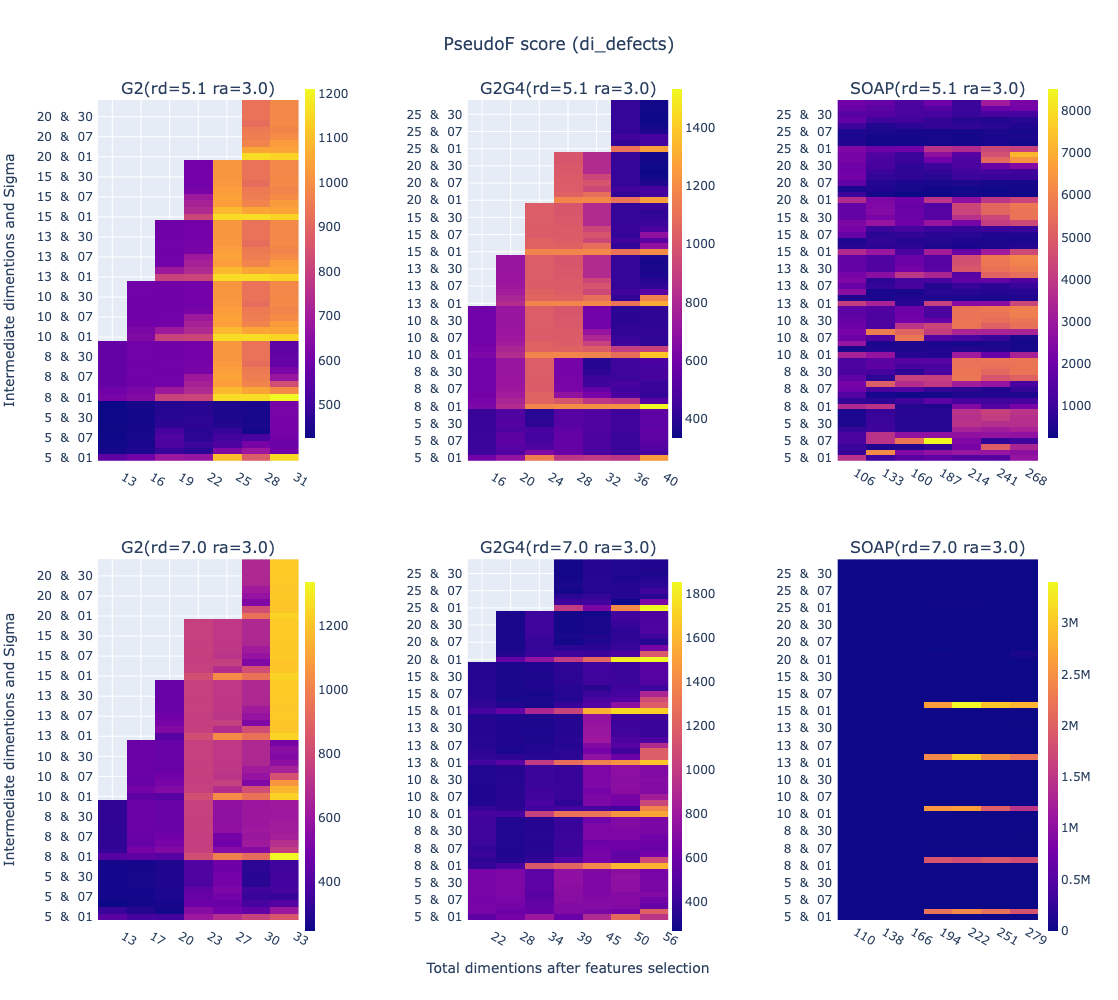

In [1]:
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_hyperparameters(hyperparameter_data_file: str = None):
    if hyperparameter_data_file == None:
        hyperparameter_data_file = f'train_and_predicted_cluster_score.csv'

    df = pd.read_csv(
        hyperparameter_data_file,
        header=0,
        sep='\t',
        encoding='utf-8',
        index_col=0,
    ).reset_index(drop=True)

    optimized_hyperparameter_data_file = hyperparameter_data_file[:-4]+'_optimized.csv'
    optimized_hyperparameters_df = pd.DataFrame(columns=df.columns)
    optimized_hyperparameters_df.to_csv(
        optimized_hyperparameter_data_file,
        sep='\t',
        encoding='utf-8',
        mode='w',
    )
    descriptors = sorted(set(df['Descriptor']))
    ra = sorted(set(df['ra']))
    rd = sorted(set(df['rd']))
    rd_ra = [f'(rd={d} ra={a})' for d in rd for a in ra]
    inter_dims = np.array(sorted(set(df['Intermediate dimensions'])))
    no_of_clusters = sorted(set(df['Cluster number']))
    tot_dim_bvt = sorted(set(df['Total dimensions before VT']))
    final_reduced_dim = sorted(set(df['Final reduced dimensions']))
    #
    df['Intermediate dimensions and Sigma'] = [
        f'{i} & {s} & (rd={d} ra={a})'
        if len(str(s)) == 2 else f'{i} & 0{s} & (rd={d} ra={a})'
        for i, s, d, a in zip(
            df['Intermediate dimensions'],
            df['Sigma'],
            df['rd'],
            df['ra'],
        )
    ]

    df['Descriptor and Total dimensions after VT'] = [
        f'{des} & {i}' for i, des in zip(
            df['Total dimensions after VT'],
            df['Descriptor'],
        )
    ]

    data = df.pivot_table(
        values='PseudoF',
        index=
        'Intermediate dimensions and Sigma',  # VT, Sigma, and Inter_dimensions',
        columns='Descriptor and Total dimensions after VT',
    )

    data_indices = list(data.index)

    new_data_indices = []
    for data_i in data_indices:
        inter_dim_ = int(data_i.split('&')[0])
        new_data_indices.append(
            str(np.where(inter_dims == inter_dim_)[0][0] + 1) + '_' + data_i)

    # data.index = new_data_indices
    data['index'] = new_data_indices
    data = data.sort_values(by=['index'])
    data = data.drop(columns=['index'])

    no_of_columns = len(descriptors)
    no_of_rows = len(rd_ra)
    horizontal_spacing = 0.18
    vertical_spacing = 0.12
    if no_of_columns == 3:
        c_x = [0.21, 0.6, 1.0]
    height = 500 * no_of_rows
    if no_of_rows == 2:
        c_y = [0.8, 0.2]
        length = 0.45

    if no_of_rows == 1:
        c_y = [0.5]
        length = 0.8

    subplot_titles = [f'{des}{rd_ra_}' for rd_ra_ in rd_ra for des in descriptors]
    fig = make_subplots(
        rows=no_of_rows,
        cols=no_of_columns,
        horizontal_spacing=horizontal_spacing,
        vertical_spacing=vertical_spacing,
        subplot_titles=subplot_titles,
    )

    # data_ra_rd = data

    for r_i, rd_ra_ in enumerate(rd_ra):
        selected_indices = [i for i in data.index if rd_ra_ in i]
        data_rd_ra = data.loc[selected_indices]
        plot_y_tick_labels = [
            f"{i.split('&')[0]} & {i.split('&')[1]}" for i in data_rd_ra.index
        ]
        data_rd_ra.set_index([plot_y_tick_labels], drop=True, inplace=True)
        for c_i, des_dim_bvt in enumerate(zip(descriptors, tot_dim_bvt)):
            data_des = data_rd_ra[[
                c for c in data_rd_ra.columns if f'{des_dim_bvt[0]} &' in c
            ]]
            df_data = data_des.dropna(how='all', axis=0).dropna(how='all', axis=1)
            plot_x_tick_labels = [c.split('&')[1] for c in df_data.columns]
            df_data.columns = [
                c if len(c) == 4 else f'  {c}' for c in plot_x_tick_labels
            ]

            column_wise_max = np.array(df_data.max())
            hyperparameters_ = np.array([
                f'{a} & {b}'
                for a, b in zip(list(df_data.idxmax().index), df_data.idxmax())
            ])
            optimized_hyperparameters = hyperparameters_[column_wise_max == max(
                column_wise_max)][0]

            rd = rd_ra_.split(' ')[0].split('=')[1]
            ra = rd_ra_.split(' ')[1].split('=')[1]
            sigma = optimized_hyperparameters.split('&')[2]
            dim_avt = optimized_hyperparameters.split('&')[0]
            inter_dim = optimized_hyperparameters.split('&')[1]
            oprimized_pseudof = max(column_wise_max)
            optimized_values = list([
                'TS-LPP', des_dim_bvt[0], rd, ra[:-1], 'nan', sigma, final_reduced_dim[0], inter_dim,
                dim_avt, des_dim_bvt[1], no_of_clusters[0], oprimized_pseudof
            ])
            optimized_hyperparameters_df = pd.DataFrame(
                [optimized_values], columns=optimized_hyperparameters_df.columns)
            optimized_hyperparameters_df.to_csv(optimized_hyperparameter_data_file,
                                                sep='\t',
                                                encoding='utf-8',
                                                mode='a',
                                                header=False)

            fig.add_trace(
                go.Heatmap(z=df_data,
                           x=df_data.columns,
                           y=df_data.index,
                           colorbar=dict(
                               x=c_x[c_i],
                               y=c_y[r_i],
                               thickness=10,
                               len=length,
                           )),
                row=r_i + 1,
                col=c_i + 1,
            )

    fig.update_xaxes(title='Total dimentions after features selection',
                     row=no_of_rows,
                     col=2)
    for r_i in range(1, no_of_rows + 1):
        fig.update_yaxes(
            title='Intermediate dimentions and Sigma',
            row=r_i,
            col=1,
        )

    fig.update_layout(
        title_text="PseudoF score (di_defects)",
        title_x=0.5,
        height=height,
    )
    fig.write_html(hyperparameter_data_file[:-4]+'.html')
    fig.write_image(hyperparameter_data_file[:-4]+'.png')
    fig.show()
    return 


plot_hyperparameters(hyperparameter_data_file=f'./dim_reduction/TsLPP/train_cluster_score.csv')



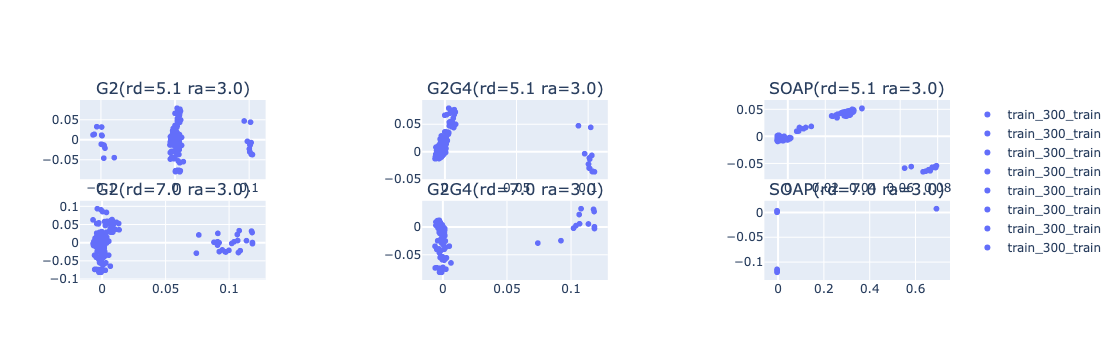

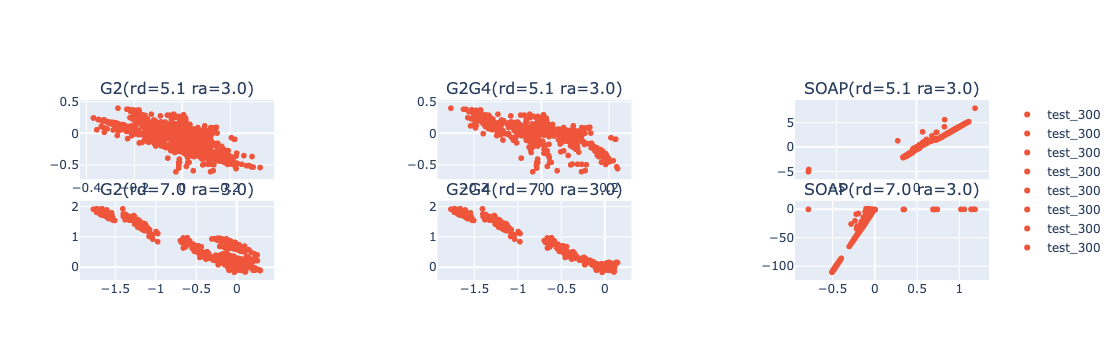

In [56]:
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import os


def plot_data():
    in_dir = './dim_reduction/TsLPP/'
    file1 = f'./dim_reduction/TsLPP/train_and_predicted_cluster_score_optimized.csv'
    file2 = f'./dim_reduction/TsLPP/train_cluster_score_optimized.csv'
    optimized_hyperparamters_df = pd.DataFrame()
    for l_, file in zip(['predicted', 'train'], [file1, file2]):
        if os.path.isfile(file):
            df_input = pd.read_csv(file, sep='\t', header=0, dtype='object')
            df_input['train_or_test'] = [l_] * df_input.shape[0]
            optimized_hyperparamters_df = pd.concat(
                [df_input, optimized_hyperparamters_df], axis=0)
        else:
            print(f'{file} is not availabel.')
            exit()

    input_files = []
    for index, row_ in optimized_hyperparamters_df.iterrows():
        row = np.array(row_)
        dim_reduc_model = row[1]
        descriptor = row[2]
        d, a, vt, sigma, final_reduced_dim, inter_dim, tot_dim_avt, tot_dim_bvt, cluster_no = row[
            3:12]
        l_ = row[-1]
        train_des_file = f'{in_dir}train_2D_TS-LPP_{descriptor}_{d}_{a}_{int(sigma)}_{int(inter_dim)}_{int(tot_dim_avt)}_{int(tot_dim_bvt)}_{vt}.csv'
        if os.path.isfile(train_des_file):
            input_files.append(train_des_file)
            df = pd.read_csv(
                train_des_file,
                header=0,
                sep='\t',
                encoding='utf-8',
                index_col=0,
            )

    descriptors = ['G2', 'G2G4', 'SOAP']
    ra = [3.0]
    rd = [5.1, 7.0]
    rd_ra = [f'(rd={d} ra={a})' for d in rd for a in ra]
    no_of_columns = len(descriptors)
    no_of_rows = len(rd_ra)
    horizontal_spacing = 0.18
    vertical_spacing = 0.12
    if no_of_columns == 3:
        c_x = [0.21, 0.6, 1.0]
    height = 500 * no_of_rows
    if no_of_rows == 2:
        c_y = [0.8, 0.2]
        length = 0.45

    if no_of_rows == 1:
        c_y = [0.5]
        length = 0.8
    subplot_titles = [
        f'{des}{rd_ra_}' for rd_ra_ in rd_ra for des in descriptors
    ]
    fig = make_subplots(
        rows=no_of_rows,
        cols=no_of_columns,
        horizontal_spacing=horizontal_spacing,
        vertical_spacing=vertical_spacing,
        subplot_titles=subplot_titles,
    )
    rd_ra = [f'{d}_{a}' for d in rd for a in ra]

    for input_file in input_files:
        for r_i, rd_ra_ in enumerate(rd_ra):
            if rd_ra_ in input_file:
                for c_i, des in enumerate(descriptors):
                    if des in input_file:
                        df = pd.read_csv(
                            input_file,
                            header=0,
                            sep='\t',
                            encoding='utf-8',
                            index_col=0,
                        )

                        fig.add_trace(px.scatter(df, 
                                                 x='D1',
                                                 y='D2',
                                                 color='m_lables',
                                                ).data[0],
                                      
                                      
                                      row=r_i + 1,
                                      col=c_i + 1)
    fig.show()
    fig = make_subplots(
        rows=no_of_rows,
        cols=no_of_columns,
        horizontal_spacing=horizontal_spacing,
        vertical_spacing=vertical_spacing,
        subplot_titles=subplot_titles,
    )
    rd_ra = [f'{d}_{a}' for d in rd for a in ra]

    for input_file in input_files:
        for r_i, rd_ra_ in enumerate(rd_ra):
            if rd_ra_ in input_file:
                for c_i, des in enumerate(descriptors):
                    if des in input_file:
                        df = pd.read_csv(
                            input_file,
                            header=0,
                            sep='\t',
                            encoding='utf-8',
                            index_col=0,
                        )

                        fig.add_trace(px.scatter(df, 
                                                 x='D1',
                                                 y='D2',
                                                 color='m_lables',
                                                ).data[1],
                                      
                                      
                                      row=r_i + 1,
                                      col=c_i + 1)
    fig.show()
    return


plot_data()